In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl

In [2]:
# print(plt.style.available)
# # plt.style.use('fivethirtyeight') 
# plt.style.use('default') 

# Load Dataset

In [3]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
]
df = df[cols]
# df_deceased = df[df.TypeOfDonor_NOTR == 'Deceased'][cols]
# df_living = df[df.TypeOfDonor_NOTR == 'Living'][cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

# Finding relevant DESA using visualisation

In [4]:
df.DESA_Status.value_counts()

No MFI         2840
No DESA         853
No HLAE-Abs     558
DESA            439
Name: DESA_Status, dtype: int64

Top curve: 75.64, Middle curve:  54.92, Lower curve: 33.85
10-Year Gap is:  21.07
1-Year Gap is:  12.12


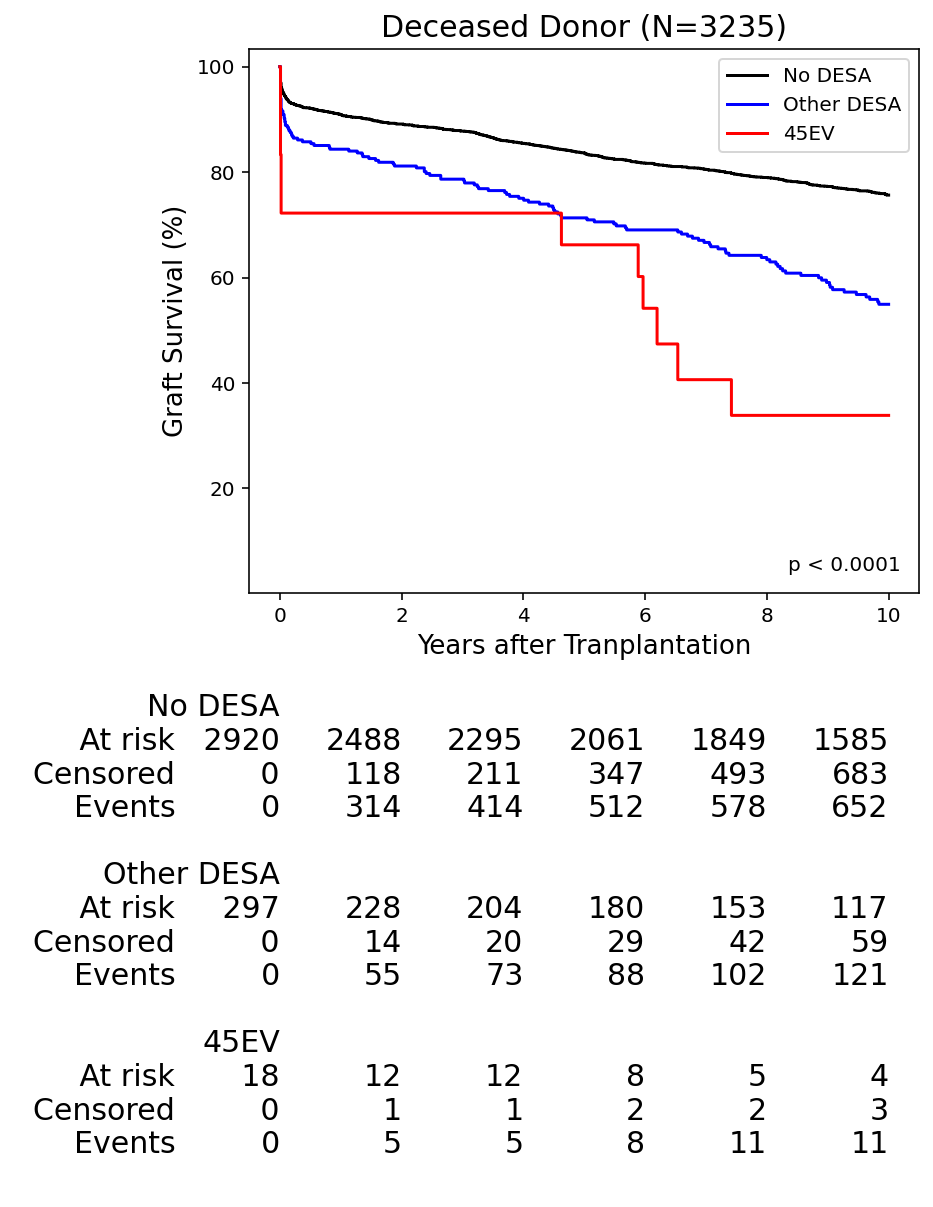

In [5]:
# kmfs = kaplan_meier_curves(df, desa_spec= class_I | class_II_dr | class_II_dq, labels=labels)
confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
# treatments = [ 'Other_DESA', 'Specific_DESA']
ep = {'45EV'}
labels = ['No DESA', 'Other DESA', f'{next(iter(ep))}']
# labels = ['Other DESA', f'{next(iter(ep))}']
# ep = RELEVANT_DESA_BAD.union(RELEVANT_DESA_GOOD_OLD)
# ep = good_epitopes
df_tret_group = create_treatment_grups(df, [ep])
df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
# kmfs = kaplan_meier_curves(df_weight, desa_spec=ep, labels=labels, adjust=False)
# plot_kaplan_meier_curve(kmfs)

kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, verbose=True, title='Deceased Donor (N=3235)', grid=False)

# DESA Relevance
## Bad DESA
### Deceased Donor [Inference Set]

Top curve: 75.56, Middle curve:  63.41, Lower curve: 37.67
10-Year Gap is:  25.74
1-Year Gap is:  17.19


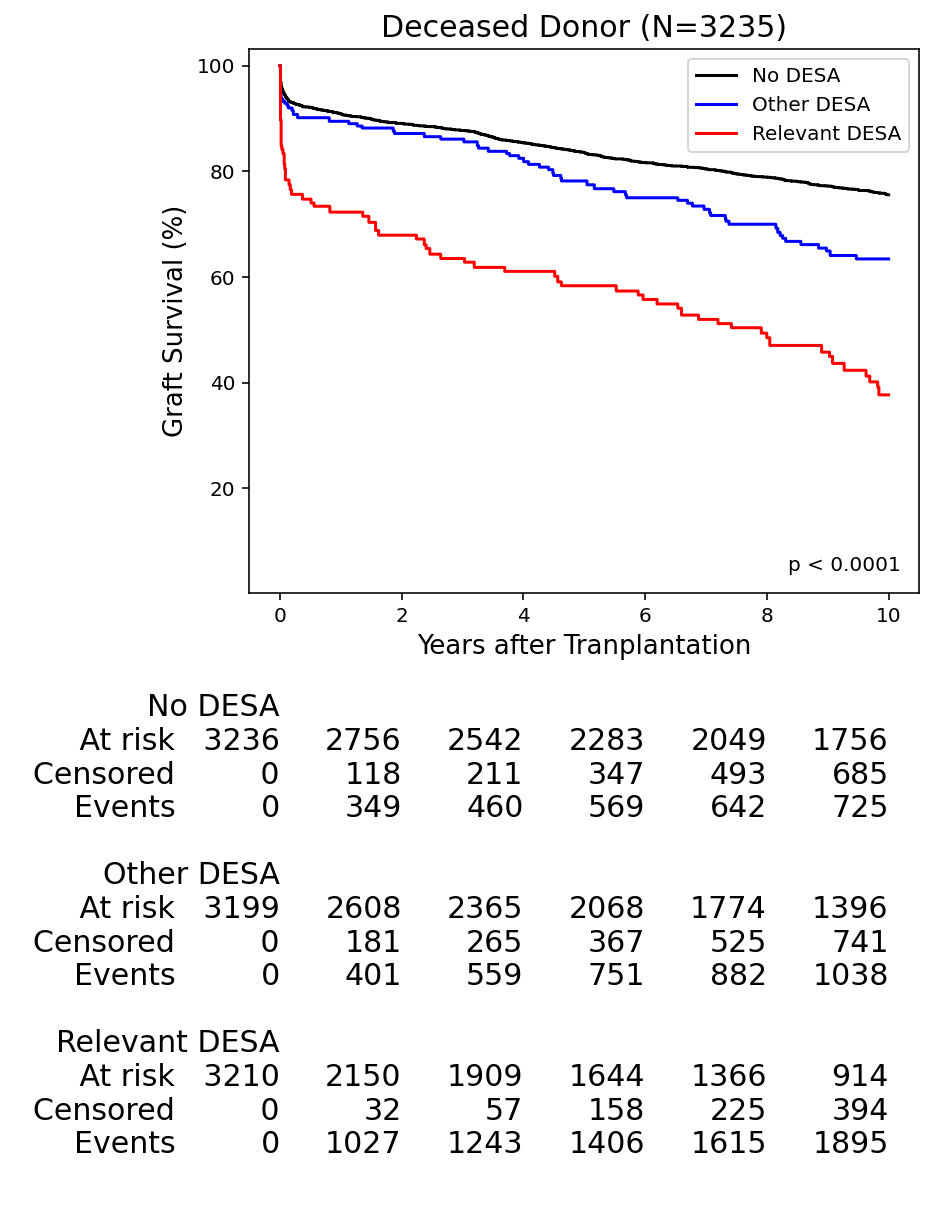

In [6]:
from src.constants import *

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
labels = ['No DESA', 'Other DESA', 'Relevant DESA']


RELEVANT_DESA_BAD = {
    '71TD', '144QL', '70DRA', '80TLR', '76ED', '70DA', '45EV', '67F', '76ET', '163RG', '67VG', '150AAH', '158T', 
    '62QE', '45GV', '45KE', '71A', '66NH', '80TA', '114R', '44KM'
}

df_treat_group = create_treatment_grups(df, [RELEVANT_DESA_BAD])
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)

# kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_BAD, labels=labels, adjust=False)
# plot_kaplan_meier_curve(kmfs, p_value, title= 'Deceased Donor (N=3235)', grid=False)
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_BAD, labels=labels,  adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, title= 'Deceased Donor (N=3235)', grid=False, verbose=True)

### Living Donor [Test Set]

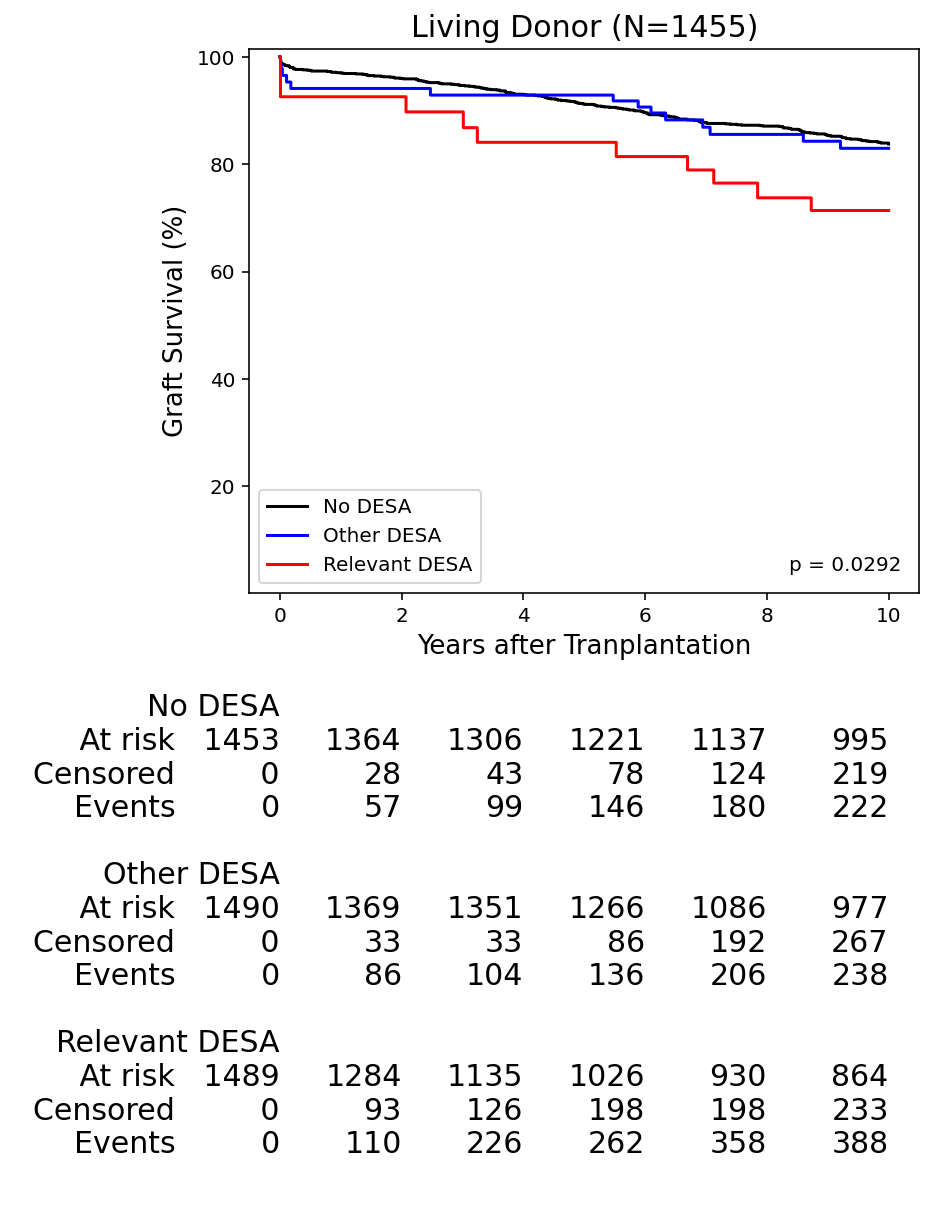

In [7]:
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
labels = ['No DESA', 'Other DESA', 'Relevant DESA']

RELEVANT_DESA_BAD = {
    '71TD', '144QL', '70DRA', '80TLR', '76ED', '70DA', '45EV', '67F', '76ET', '163RG', '67VG', '150AAH', '158T', 
    '62QE', '45GV', '45KE', '71A', '66NH', '80TA', '114R', '44KM'
}

df_treat_group = create_treatment_grups(df, [RELEVANT_DESA_BAD])
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_BAD, donor_type='Living', labels=labels, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, title='Living Donor (N=1455)', grid=False)

## Good DESA

### Deceased Donor [Inference Set]

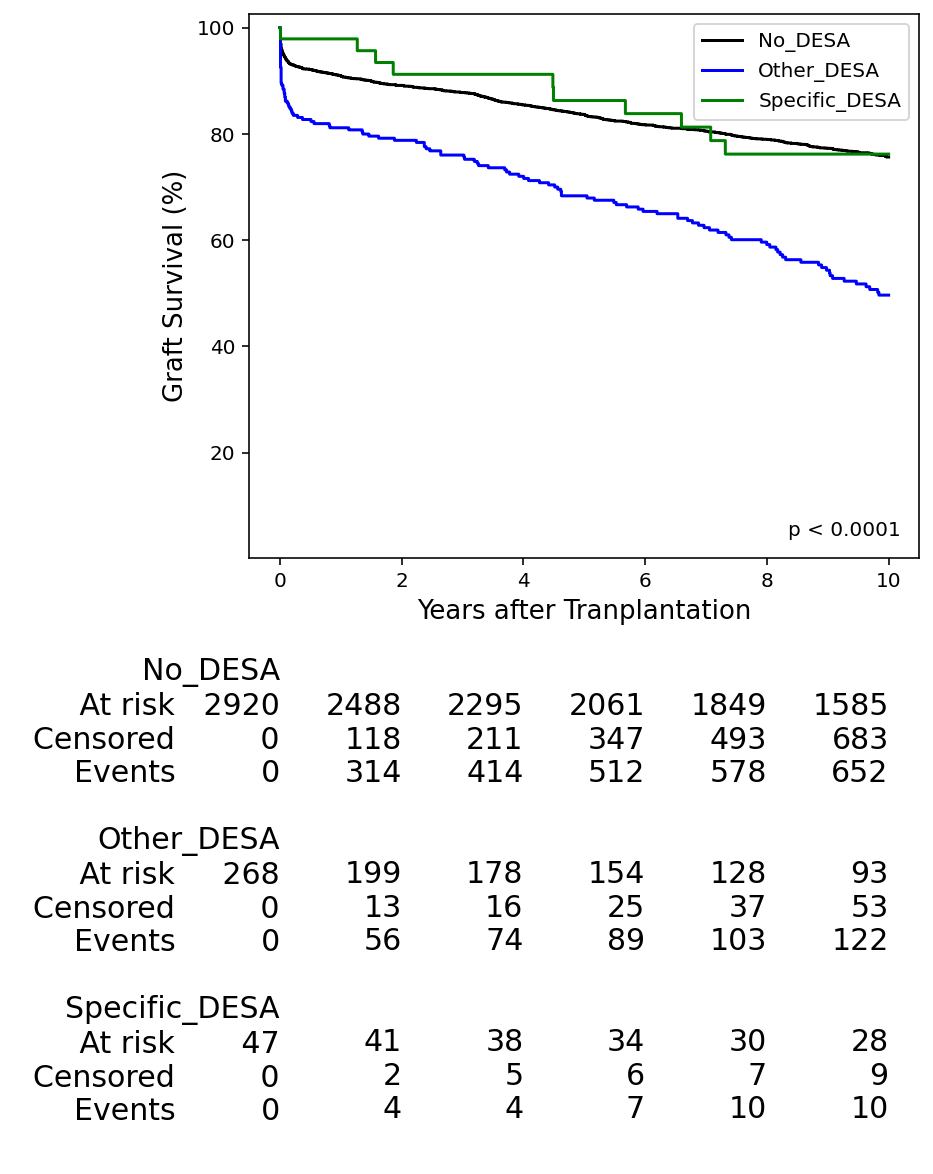

In [9]:
RELEVANT_DESA_GOOD = {'163RW', '37FL', '173K', '152RA', '80I'}

df_treat_group = create_treatment_grups(df, [RELEVANT_DESA_GOOD])

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_GOOD, labels=treatments, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, colors=['black', 'blue', 'green'], grid=False)

### Living Donor [Test Set]

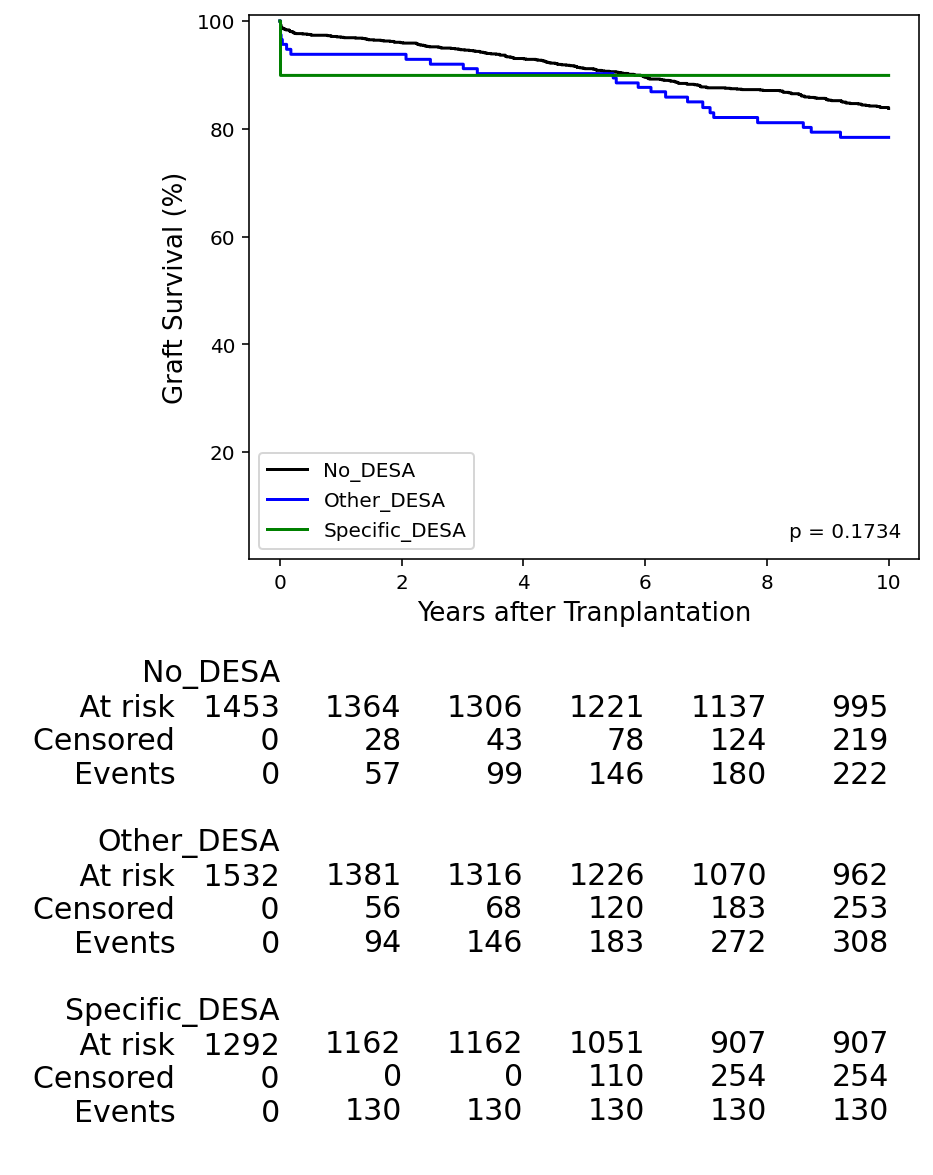

In [10]:
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']

RELEVANT_DESA_GOOD = {'163RW', '37FL', '173K', '152RA', '80I'}

df_treat_group = create_treatment_grups(df, [RELEVANT_DESA_GOOD])
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_GOOD, donor_type='Living', labels=treatments,  adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, colors=['black', 'blue', 'green'], grid=False)

# Combining the figures for all donors Bad & Good

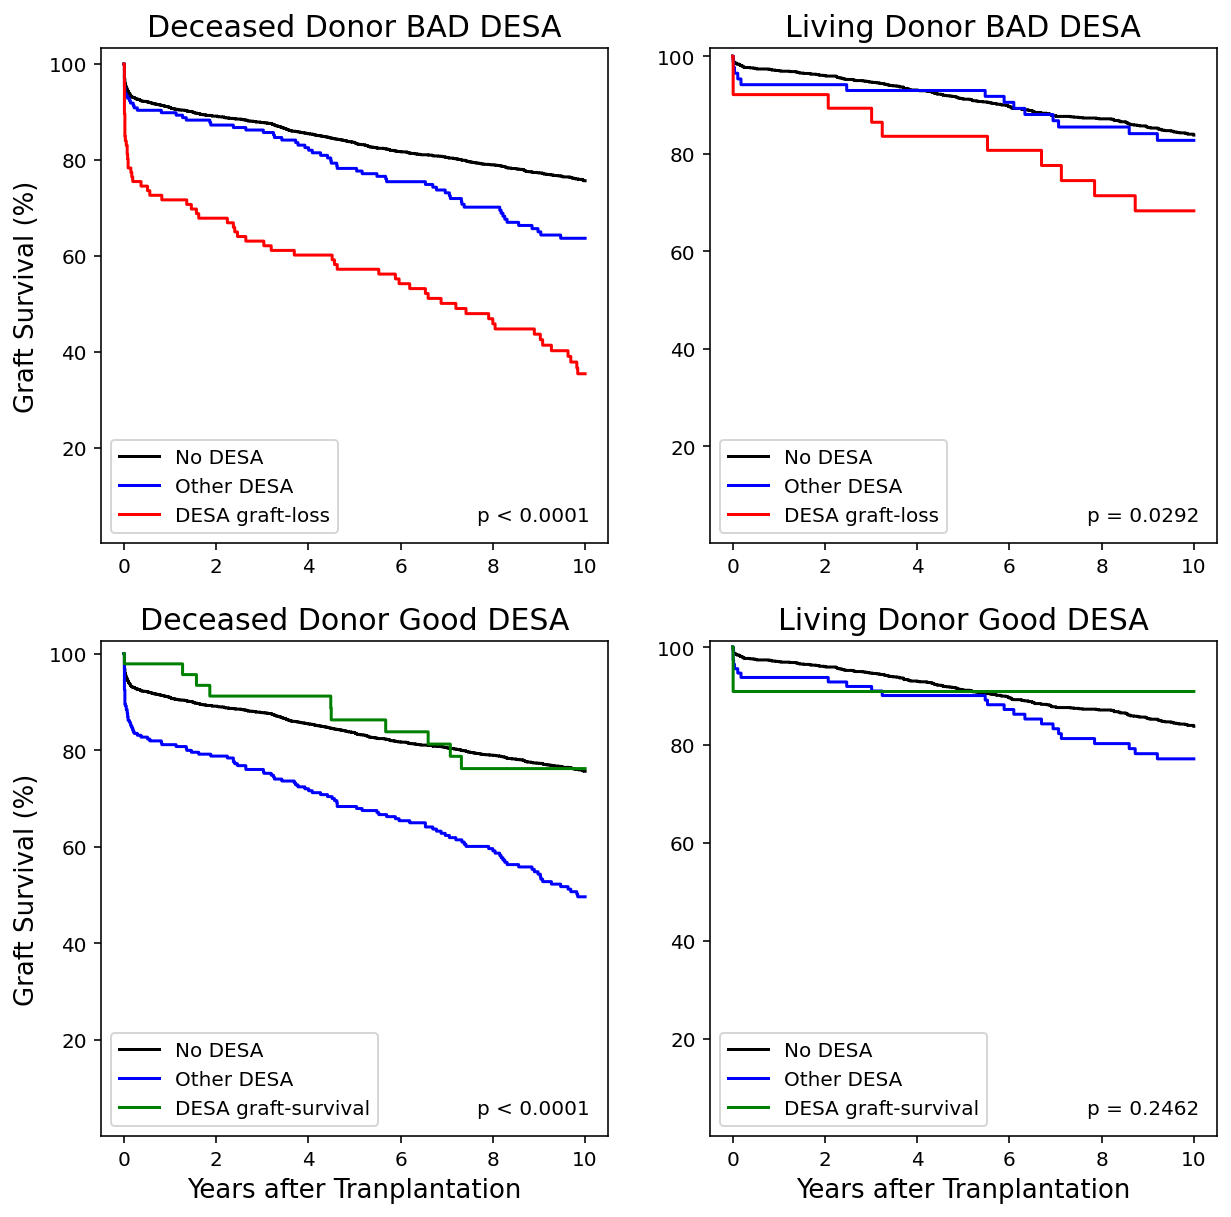

In [11]:
import matplotlib.pyplot as plt

labels = ['No DESA', 'Other DESA', 'DESA graft-loss']
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# BAD DESA
df_treat_group_bad = create_treatment_grups(df, [RELEVANT_DESA_BAD])
kmfs, p_value_bad = kaplan_meier_curves(df_treat_group_bad, desa_spec=RELEVANT_DESA_BAD, donor_type='Deceased', labels=labels,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value_bad, add_counts=False, ax=ax[0, 0], title='Deceased Donor BAD DESA', xlabel=None)
kmfs, p_value_bad = kaplan_meier_curves(df_treat_group_bad, desa_spec=RELEVANT_DESA_BAD, donor_type='Living', labels=labels,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value_bad, add_counts=False, ax=ax[0, 1], title='Living Donor BAD DESA', xlabel=None, ylabel=None)

labels = ['No DESA', 'Other DESA', 'DESA graft-survival']
# GOOD DESA
df_treat_group_good = create_treatment_grups(df, [RELEVANT_DESA_GOOD_OLD])
kmfs, p_value_good = kaplan_meier_curves(df_treat_group_good, desa_spec=RELEVANT_DESA_GOOD, donor_type='Deceased', labels=labels,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value_good, add_counts=False, ax=ax[1, 0], title='Deceased Donor Good DESA', colors=['black', 'blue', 'green'])
kmfs, p_value_good = kaplan_meier_curves(df_treat_group_good, desa_spec=RELEVANT_DESA_GOOD, donor_type='Living', labels=labels,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value_good, add_counts=False, ax=ax[1, 1], title='Living Donor Good DESA', ylabel=None, colors=['black', 'blue', 'green'])


# Combining DESA for Living & Deceased donors Early vs Late

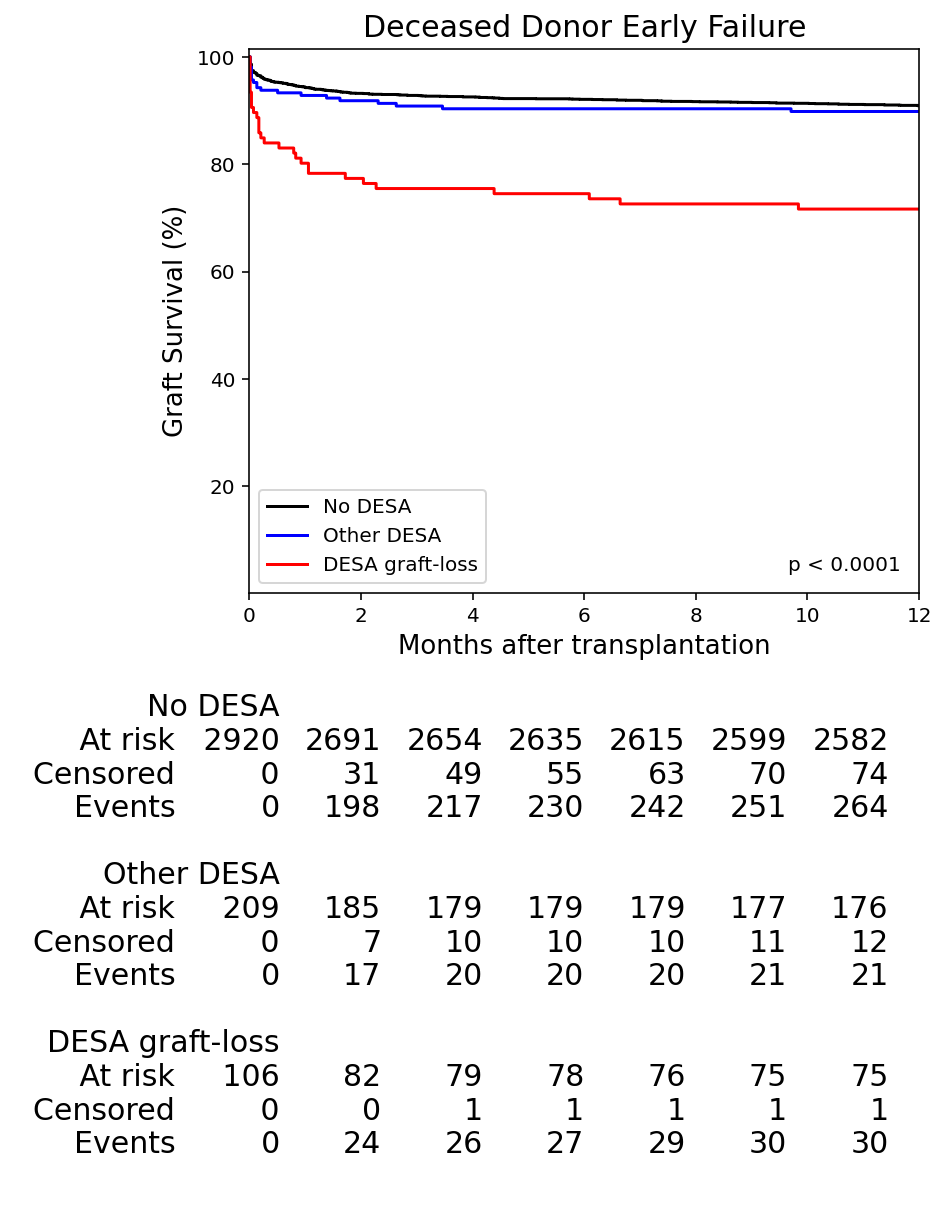

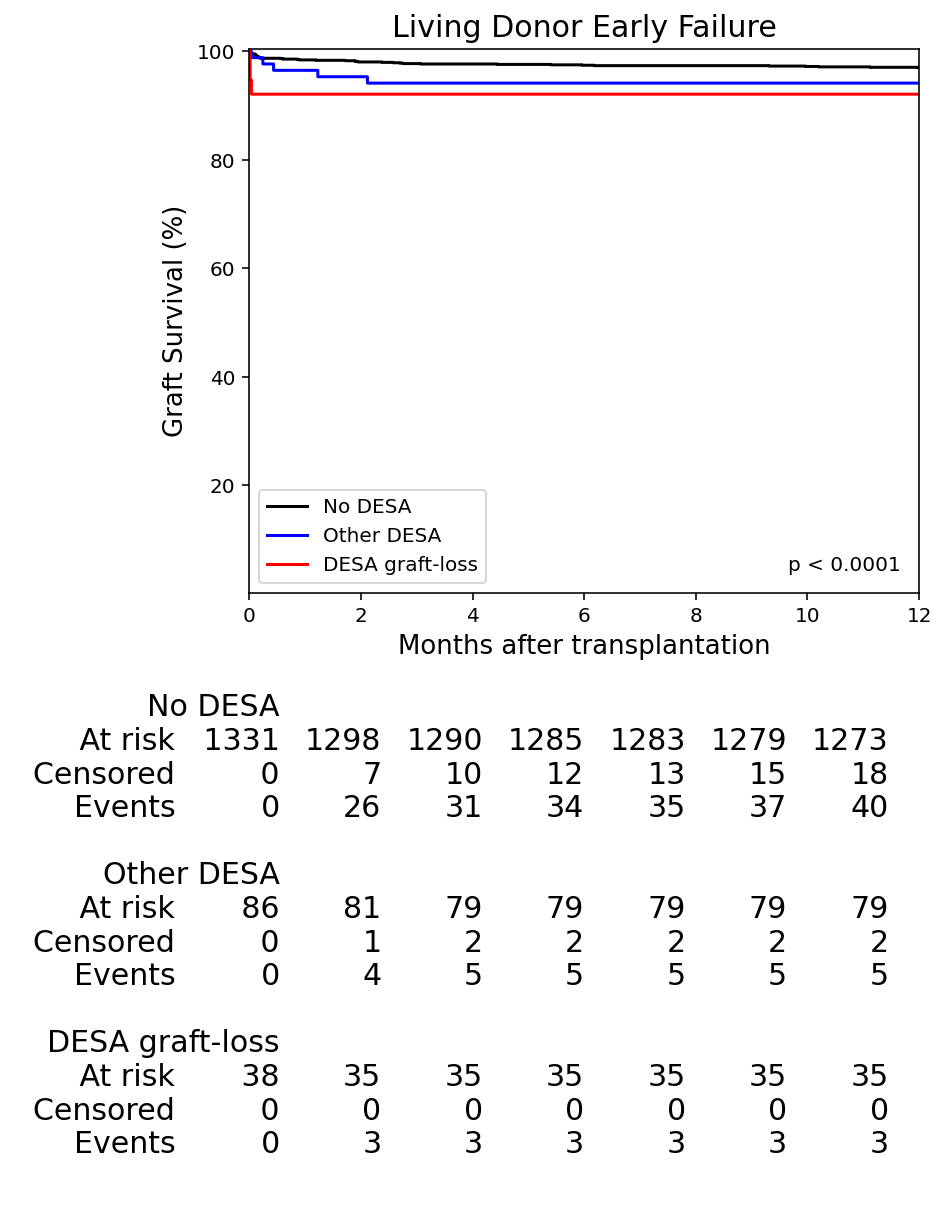

In [37]:
import matplotlib.pyplot as plt

labels = ['No DESA', 'Other DESA', 'DESA graft-loss']
# DESA Early Failure
timeline = np.linspace(0, 12, 1000)
df_early = df.copy(deep=True)
df_early['GraftSurvival10Y_R'] = df_early['GraftSurvival10Y_R'] * 12
# To have an accurate p-value for the early graft loss, we need to censor the samples after 12 months so the survival analysis would not drop/change
df_early.loc[df_early['GraftSurvival10Y_R'] > 12, 'FailureCode10Y_R'] = 0 

df_treat_group_early = create_treatment_grups(df_early, [RELEVANT_DESA_BAD])
kmfs, p_value = kaplan_meier_curves(df_treat_group_early, desa_spec=RELEVANT_DESA_BAD, donor_type='Deceased', 
                                    weightings='fleming-harrington', labels=labels, timeline=timeline)
plot_kaplan_meier_curve(kmfs, p_value, title='Deceased Donor Early Failure', xlabel='Months after transplantation', x_lim=[0, 12])
kmfs, p_value = kaplan_meier_curves(df_treat_group_early, desa_spec=RELEVANT_DESA_BAD, donor_type='Living', 
                                    weightings='fleming-harrington', labels=labels, timeline=timeline)
plot_kaplan_meier_curve(kmfs, p_value, title='Living Donor Early Failure', xlabel='Months after transplantation', x_lim=[0, 12])

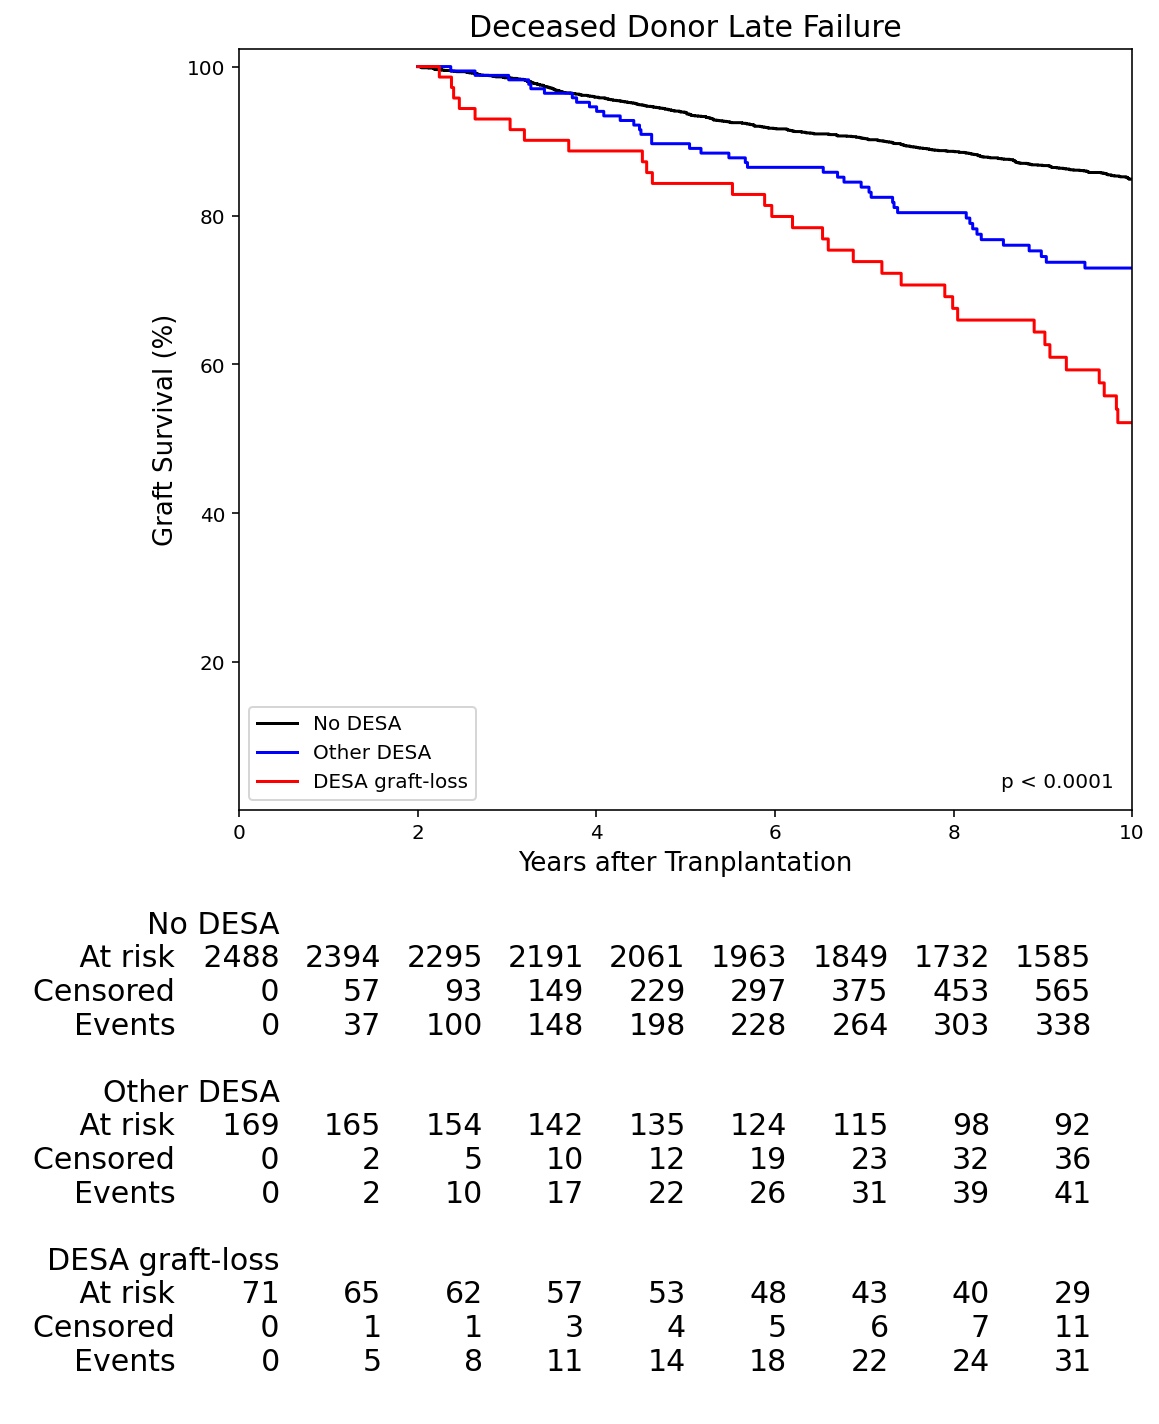

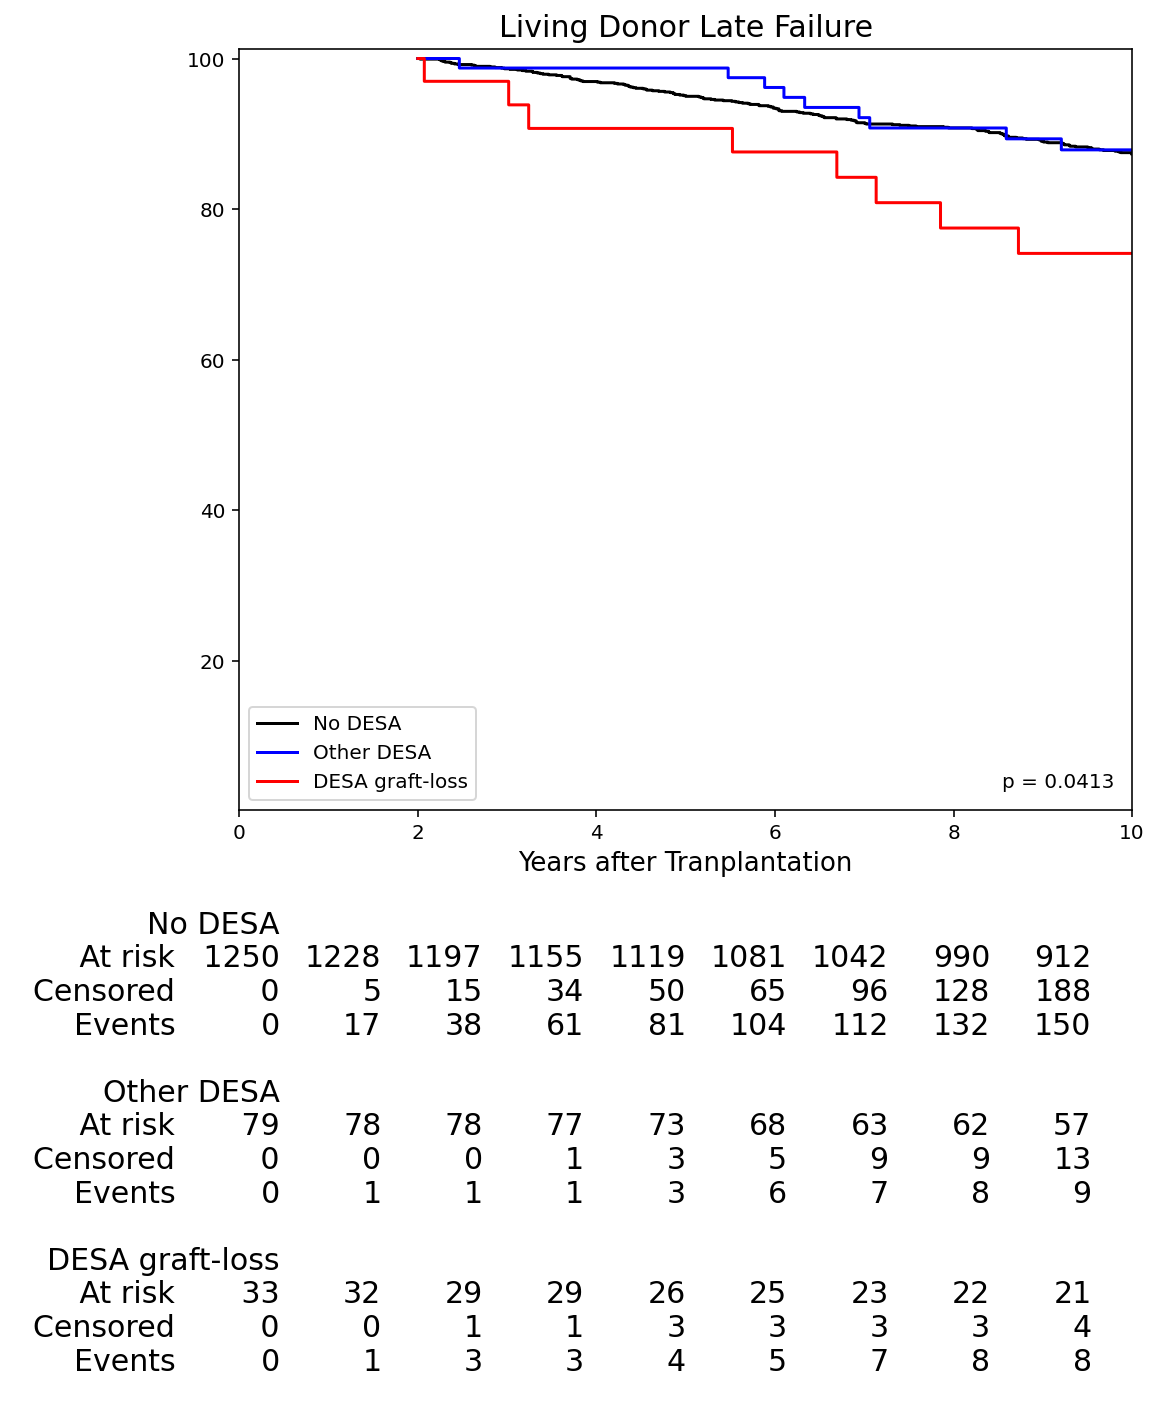

In [46]:
# DESA Late Failure
start = 2
timeline = np.linspace(start, 10, 1000)
df_late = df.copy(deep=True)
df_late.loc[df_late['GraftSurvival10Y_R'] <= 1, 'FailureCode10Y_R'] = 0

df_late = df_late[df_late['GraftSurvival10Y_R'] > start]

df_treat_group_late = create_treatment_grups(df_late, [RELEVANT_DESA_BAD])
kmfs, p_value = kaplan_meier_curves(df_treat_group_late, desa_spec=RELEVANT_DESA_BAD, donor_type='Deceased', 
                                    weightings='wilcoxon', labels=labels, timeline=timeline, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, title='Deceased Donor Late Failure', x_lim=[0, 10])
kmfs, p_value = kaplan_meier_curves(df_treat_group_late, desa_spec=RELEVANT_DESA_BAD, donor_type='Living', 
                                     weightings='fleming-harrington', p=0, q=1, labels=labels, timeline=timeline, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, title='Living Donor Late Failure', ylabel=None, x_lim=[0, 10])